In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as kt
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as tf

In [2]:
# sp_data = pd.read_csv('/content/drive/MyDrive/PRACTICA_9/MODELOS_GENERATIVOS/TEORIA/all_stocks_5yr.csv')
sp_data = pd.read_csv('../data/all_stocks_5yr.csv')

In [3]:
sp_data = sp_data.pivot(index = 'date', columns='Name', values='close')

In [4]:
sp_data.dropna(axis=1, inplace=True)

In [5]:
sp_data.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


In [6]:
retornos = np.log(sp_data).diff().dropna(axis=0)

In [7]:
retornos.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010705,-0.019857,-0.006485,0.010368,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,...,0.002476,-0.001334,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,0.000448,-0.013227,0.002675,-0.025386,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,...,0.003526,0.003198,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.002909,0.026963,0.004696,-0.001905,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,...,0.000352,0.005837,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.003806,-0.046780,-0.001648,-0.000900,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,...,-0.007062,0.016789,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,-0.053681,0.035806,0.002027,-0.013876,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,...,0.015820,-0.008360,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116


In [8]:
retornos.shape

(1258, 470)

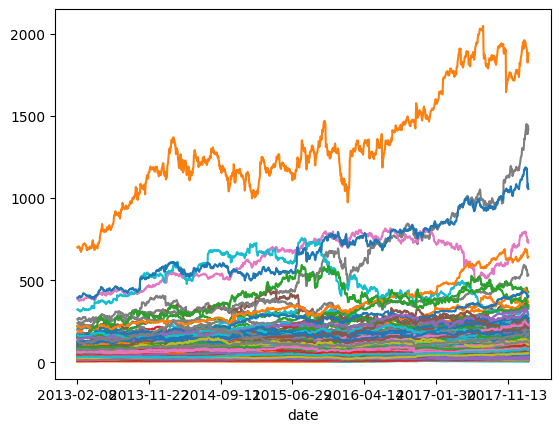

In [9]:
sp_data.plot(legend=False);

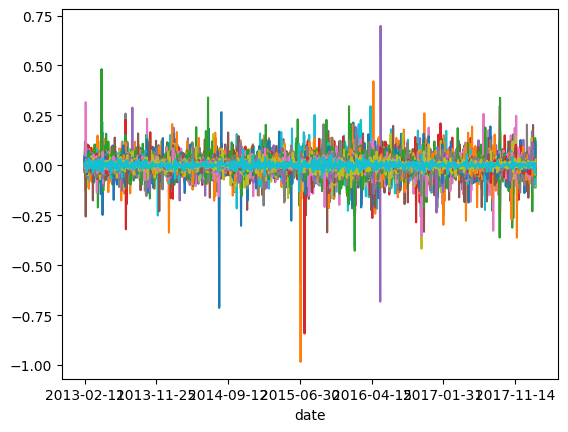

In [10]:
retornos.plot(legend=False);

In [11]:
x_train = np.array(retornos.T)

In [12]:
# Capa de Sampling
from keras.layers import Layer
import tensorflow as tf
class Sampling(Layer):

  def __init__(self):
    super(Sampling, self).__init__()

  def call(self, inputs):
    mu, logstd = inputs
    std = tf.exp(logstd)
    epsilon = tf.random.normal(tf.shape(mu))
    return epsilon * std + mu

In [13]:
mu = Input(shape=2)
logstd = Input(shape=2)
sample = Sampling()([mu, logstd])
sampling_mod = Model([mu, logstd], sample)

In [14]:
sampling_mod.predict([np.array([1., 2.]), np.array([0., -20.])])

1/1 [==============================] - 0s 117ms/step


array([-0.05629587,  2.        ], dtype=float32)

In [15]:
# Capa KL
from keras.layers.rnn.base_conv_rnn import InputSpec
class KL(Layer):

  def __init__(self, beta=1):
    self.beta = beta
    super(KL, self).__init__()
    

  def call(self, inputs):
    mu, logstd = inputs 
    kl_loss = 0.5 * (tf.square(mu) + tf.exp(logstd * 2.) - 1 - logstd * 2.)
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    self.add_loss(kl_loss)
    return inputs

In [16]:
mu = Input(shape = 2)
logstd = Input(shape = 2)
mu2, logstd2 = KL()([mu, logstd])
kl_model = Model([mu, logstd], [mu2, logstd2])

In [17]:
kl_model.predict([np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 56ms/step


[array([[1., 2.]], dtype=float32), array([[0., 3.]], dtype=float32)]

In [18]:
kl_model.compile()

In [19]:
kl_model.evaluate([np.array([[1., 2.]]), np.array([[0., 3.]])], [np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 101ms/step - loss: 200.7144


200.7144012451172

In [20]:
# Fin de la capa KL

In [21]:
# Autoencoder

In [22]:
# Clasificador
from keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Sequential, Model

In [23]:
z_dim = 20
h_dim = 100
data_len = retornos.shape[0]

In [24]:
encoder_head = Sequential([
    Dense(h_dim, activation = 'relu'),
])

inp = Input(data_len)
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [25]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [26]:
encoder_sample.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1258)]       0           []                               
                                                                                                  
 sequential (Sequential)        (None, 100)          125900      ['input_5[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           2020        ['sequential[0][0]']             
                                                                                                  
 dense_2 (Dense)                (None, 20)           2020        ['sequential[0][0]']             
                                                                                            

In [27]:
encoder_sample.predict(x_train[3:4])

1/1 [==============================] - 1s 1s/step


array([[ 0.2804163 , -0.09339445, -0.09030081,  1.3246948 , -0.78053254,
         1.405687  ,  0.43249717, -1.6807187 , -1.2992064 , -0.43452394,
         0.57810706,  0.9022104 , -1.1487868 ,  0.04277334,  1.4389087 ,
        -0.84970963,  0.18167083,  0.1711876 , -0.17179832, -0.48458308]],
      dtype=float32)

In [28]:
# Decoder

decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(data_len, activation='tanh')
])

In [29]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               2100      
                                                                 
 dense_4 (Dense)             (None, 1258)              127058    
                                                                 
Total params: 129,158
Trainable params: 129,158
Non-trainable params: 0
_________________________________________________________________


In [30]:
vae = Sequential([encoder_mean, decoder])

In [31]:
from keras.losses import MSE
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*data_len)

1/1 [==============================] - 0s 72ms/step


<AxesSubplot: xlabel='date'>

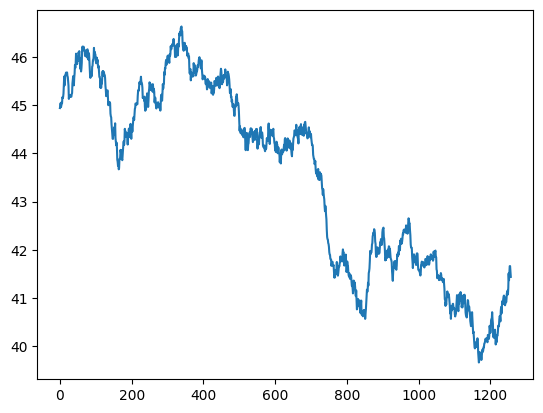

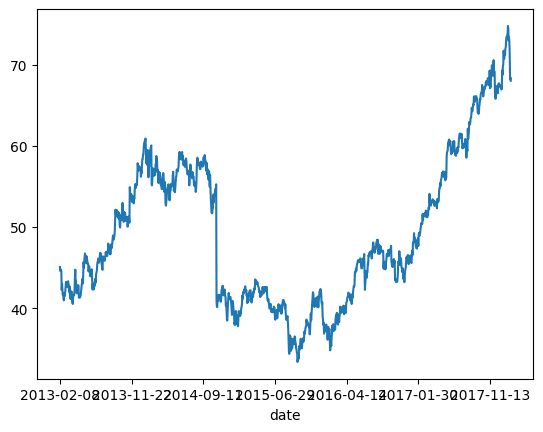

In [32]:
num = 0
pd.Series(np.exp((vae.predict(x_train[num:num+1])[0]).cumsum())*sp_data.iloc[0,num]).plot()
plt.figure()
sp_data.iloc[:,0].plot()

In [33]:
n_epochs = 1000
batch_size = 128

# history = vae.fit(x_train, x_train, validation_data = (x_test, x_test), batch_size=batch_size, epochs=n_epochs)
history = vae.fit(x_train, x_train, batch_size=batch_size, epochs=n_epochs)

Epoch 1/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.3121
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2695
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.2523
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2439
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2375
Epoch 6/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.2317
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2262
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2214
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.2169
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.2129
Epoch 11/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2091
Epoch 12/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2053
Epoch 13/1000
4/4 [==============================

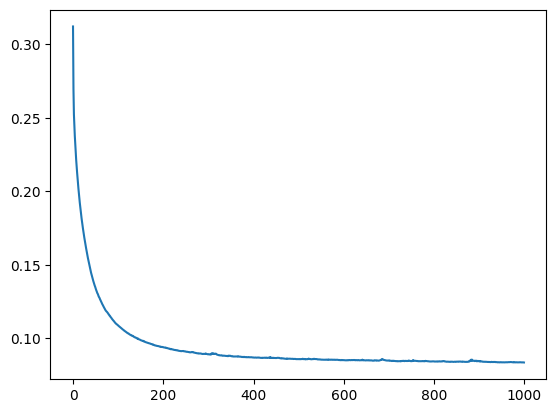

In [34]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

1/1 [==============================] - 0s 18ms/step


<AxesSubplot: xlabel='date'>

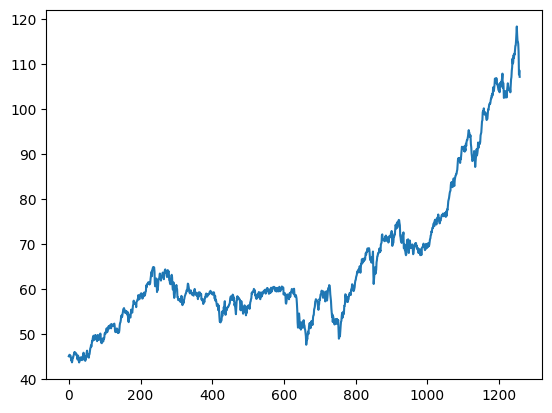

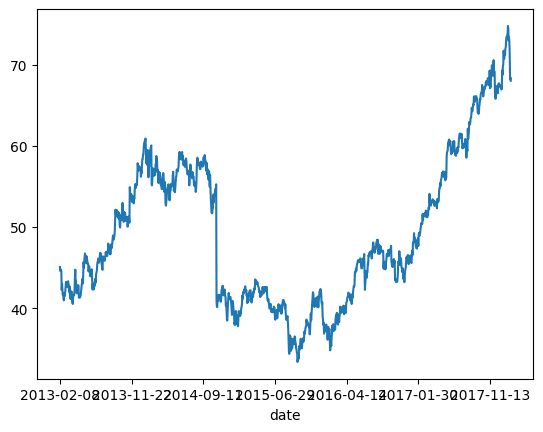

In [35]:
# Comprobación del autoencoder
num = 0
pd.Series(np.exp((vae.predict(x_train[num:num+1])[0]).cumsum())*sp_data.iloc[0,num]).plot()
plt.figure()
sp_data.iloc[:,0].plot()

In [36]:
# Generacion
sp_data.tail(2)

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-02-06,68.45,51.18,112.20,163.03,111.20,91.54,58.86,154.69,194.47,88.54,...,37.34,68.99,78.35,58.46,30.85,71.33,80.58,122.30,52.52,73.27
2018-02-07,68.06,51.40,109.93,159.54,113.62,94.22,58.67,155.15,192.34,85.35,...,42.00,66.97,76.94,58.30,31.18,71.79,80.13,120.78,54.02,73.86


In [37]:
encoder_mean.predict(x_train[0:1])

1/1 [==============================] - 0s 44ms/step


array([[ 0.2046525 ,  0.1052224 ,  0.07205001, -0.13772513, -0.11441641,
         0.10978273,  0.05632877,  0.11716485,  0.06783763, -0.07301749,
        -0.08518941,  0.09248307, -0.32071385, -0.1660877 ,  0.06462612,
        -0.00683442,  0.00061969,  0.11173833, -0.06279213,  0.00869448]],
      dtype=float32)

1/1 [==============================] - 0s 30ms/step


<AxesSubplot: >

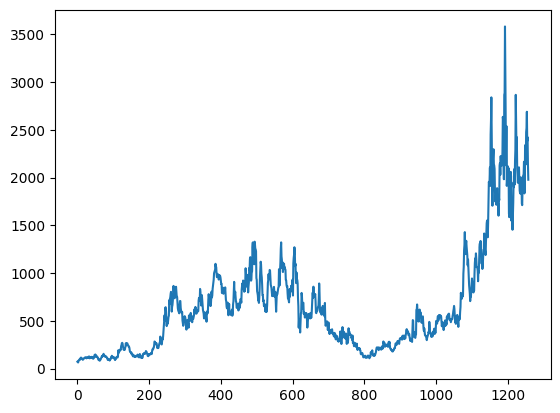

In [54]:
pd.Series(np.exp(decoder.predict([[np.random.random() for i in range(z_dim)]])[0].cumsum())*sp_data.iloc[-1,0]).plot()